In [ ]:
from google.colab import drive
drive.mount('/content/drive')
path = '.../data'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
from fastai.vision.all import *
from sklearn.model_selection import train_test_split
import os
from glob import glob
from sklearn import metrics
import numpy as np
import random
from collections import defaultdict

In [ ]:
def create_race_biased_test_set(middle_df, other_df, bias):
      """
    Adjusts the racial composition of two datasets to introduce a specified bias
    in the proportion of White individuals.

    Parameters:
        middle_df (DataFrame): The first dataset containing a "Race/Ethnicity" column.
        other_df (DataFrame): The second dataset containing a "Race/Ethnicity" column.
        bias (float): The desired proportion of White individuals in middle_df.

    Returns:
        DataFrame: A concatenated DataFrame with the modified middle_df and other_df
                   after adjusting for the racial bias.
    """

  # Calculate the current proportion of White individuals in each dataset
  prop1 = sum(middle_df['Race/Ethnicity'].str.contains('White'))/len(middle_df)
  prop2 = sum(other_df['Race/Ethnicity'].str.contains('White'))/len(other_df)

  # Adjust the middle_df dataset based on the desired bias level
  # If the target bias is lower than or equal to the current proportion,
  # oversample White individuals to reach the desired proportion
  if bias<= prop1:
    biased_middle_df = pd.concat([middle_df, middle_df[middle_df['Race/Ethnicity'].str.contains('White')].sample(int((sum(middle_df['Race/Ethnicity'].str.contains('White'))-len(middle_df)*bias)/(1-bias)), random_state = 2022)]).drop_duplicates(subset=['Path'], keep=False)
  # If the target bias is higher than the current proportion,
  # oversample non-White individuals to reduce the proportion of White individuals
  else:
    biased_middle_df = pd.concat([middle_df, middle_df[~(middle_df['Race/Ethnicity'].str.contains('White'))].sample(int((sum(~(middle_df['Race/Ethnicity'].str.contains('White')))-len(middle_df)*(1-bias))/bias), random_state = 2022)]).drop_duplicates(subset=['Path'], keep=False)

  # Adjust the other_df dataset similarly but based on bias2
  bias2 = 1-bias
  if bias2<= prop2:
    biased_other_df = pd.concat([other_df, other_df[other_df['Race/Ethnicity'].str.contains('White')].sample(int((sum(other_df['Race/Ethnicity'].str.contains('White'))-len(other_df)*bias2)/(1-bias2)), random_state = 2022)]).drop_duplicates(subset=['Path'], keep=False)
  else:
    biased_other_df = pd.concat([other_df, other_df[~(other_df['Race/Ethnicity'].str.contains('White'))].sample(int((sum(~(other_df['Race/Ethnicity'].str.contains('White')))-len(other_df)*(1-bias2))/bias2), random_state = 2022)]).drop_duplicates(subset=['Path'], keep=False)

  return(pd.concat([biased_middle_df,biased_other_df]))

def binarize_by_age(df, age):

    #Splits a dataset into two subsets based on a given age category.

    age_df = df[df['Patient Age Category']== age]
    non_age_df = df[df['Patient Age Category']!=age]
    return age_df, non_age_df

CheXpert Trained;
MIMIC Tested

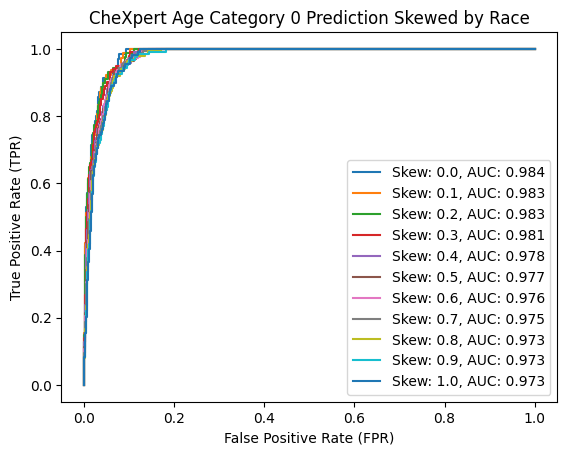

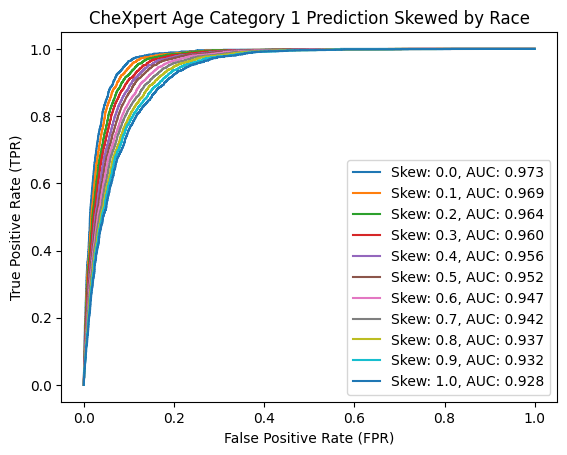

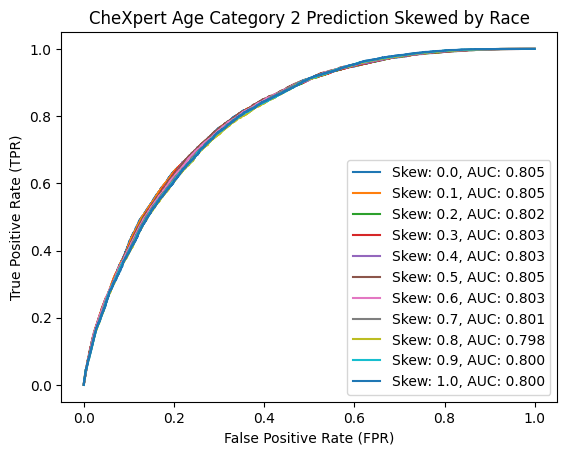

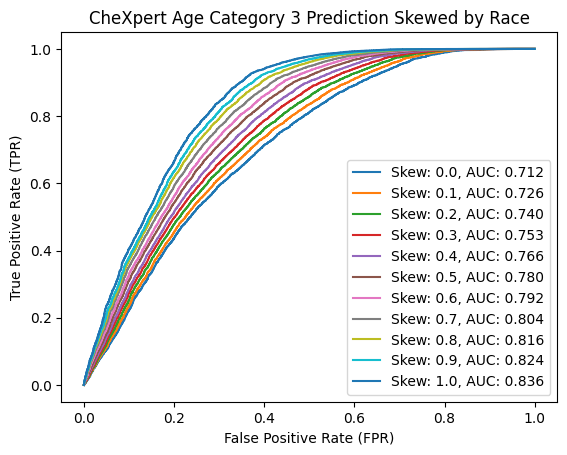

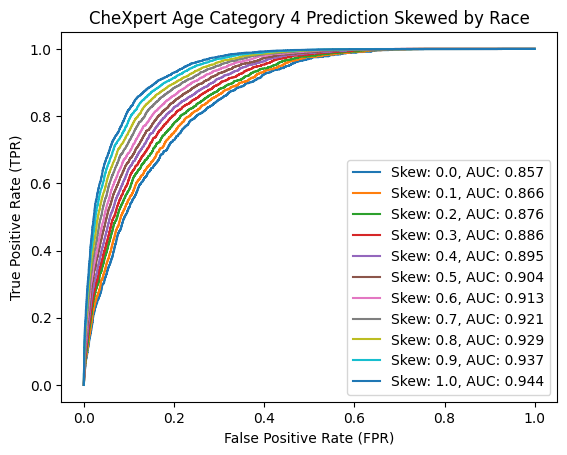

In [ ]:
ages = [0, 1, 2, 3, 4]
for age in ages:
  df = pd.read_csv(path + '/chexpert_age_mimic_test.csv')
  df = df.rename(columns={'age': 'Age'})
  df = df[~df['Race/Ethnicity'].isna()]
  df = df[df['Race/Ethnicity']!='Unknown']

  df['Age_Probability'] = df['Age_Probability'].str.rstrip(']')
  df['Age_Probability'] = df['Age_Probability'].str.lstrip('[')
  df['Age_Probability'] = df['Age_Probability'].apply(np.fromstring, sep=',', dtype = float)
  age_df, nonage_df = binarize_by_age(df, age)

  #For each bias/skew, created the appropriate skewed dataset and calculate AUCROC
  for bias in np.arange(0, 1.1, 0.1):
      biased_test_df = create_race_biased_test_set(age_df, nonage_df, bias)
      fpr, tpr, _ = metrics.roc_curve(y_true = biased_test_df['Patient Age Category'],y_score = [prob[age] for prob in biased_test_df['Age_Probability']], pos_label = age)
      auc = metrics.auc(fpr, tpr)
      plt.plot(fpr, tpr, label=f'Skew: {bias:.1f}, AUC: {auc:.3f}')
  # Add labels, title, and legend
  plt.xlabel('False Positive Rate (FPR)')
  plt.ylabel('True Positive Rate (TPR)')
  plt.legend(loc='lower right')
  plt.title('CheXpert Age Category ' + str(age) + ' Prediction Skewed by Race')
  # Show the plot
  plt.show()

CheXpert Trained; CheXpert Tested

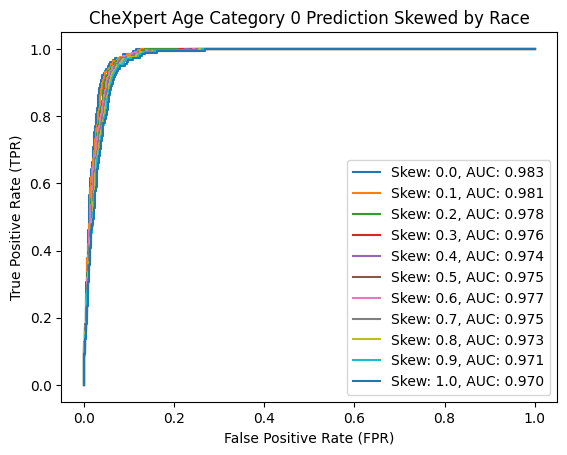

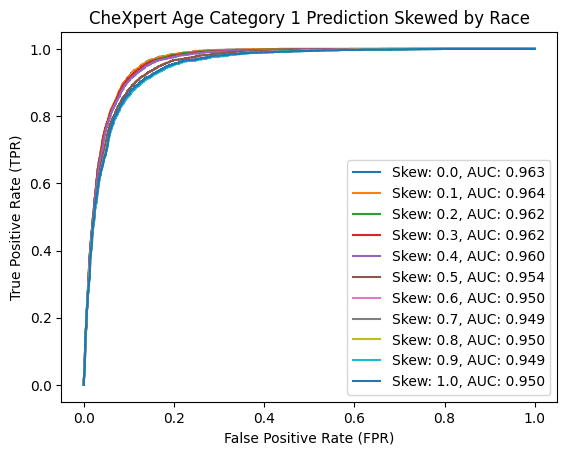

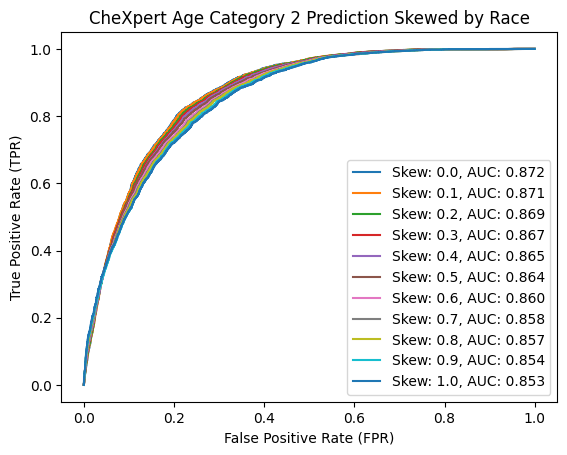

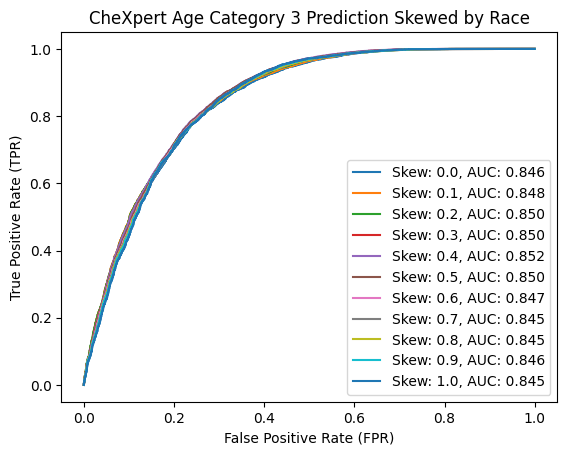

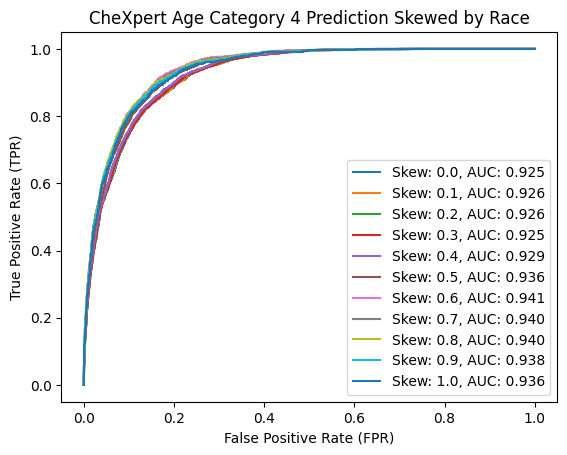

In [ ]:
ages = [0, 1, 2, 3, 4]
for age in ages:
  df = pd.read_csv(path + '/chexpert_age_chexpert_test.csv')
  df = df.rename(columns={'age': 'Age'})
  df.loc[df['PRIMARY_RACE'] == 'Asian', 'Race/Ethnicity'] = 'Non-Hispanic Asian'
  df.loc[df['PRIMARY_RACE'] == 'Black', 'Race/Ethnicity'] = 'Non-Hispanic Black'
  df.loc[df['PRIMARY_RACE'] == 'White', 'Race/Ethnicity'] = 'Non-Hispanic White'
  df.loc[df['PRIMARY_RACE'] == 'Native American', 'Race/Ethnicity'] = 'Other'
  df.loc[df['PRIMARY_RACE'] == 'Other', 'Race/Ethnicity'] = 'Other'
  df.loc[df['PRIMARY_RACE'] == 'Unknown', 'Race/Ethnicity'] = 'Unknown'
  df.loc[df['ETHNICITY'] == 'Hispanic/Latino', 'Race/Ethnicity'] = 'Other'
  df = df[~df['Race/Ethnicity'].isna()]
  df = df[df['Race/Ethnicity']!='Unknown']
  df = df.reset_index()

  df['Age_Probability'] = df['Age_Probability'].str.rstrip(']')
  df['Age_Probability'] = df['Age_Probability'].str.lstrip('[')
  df['Age_Probability'] = df['Age_Probability'].apply(np.fromstring, sep=',', dtype = float)
  age_df, nonage_df = binarize_by_age(df, 2)
  for bias in np.arange(0, 1.1, 0.1):
      biased_test_df = create_race_biased_test_set(age_df, nonage_df, bias)
      fpr, tpr, _ = metrics.roc_curve(y_true = biased_test_df['Patient Age Category'],y_score = [prob[age] for prob in biased_test_df['Age_Probability']], pos_label = age)
      auc = metrics.auc(fpr, tpr)
      plt.plot(fpr, tpr, label=f'Skew: {bias:.1f}, AUC: {auc:.3f}')
  # Add labels, title, and legend
  plt.xlabel('False Positive Rate (FPR)')
  plt.ylabel('True Positive Rate (TPR)')
  plt.legend(loc='lower right')
  plt.title('CheXpert Age Category ' + str(age) + ' Prediction Skewed by Race')
  # Show the plot
  plt.show()

MIMIC Trained;
MIMIC Tested

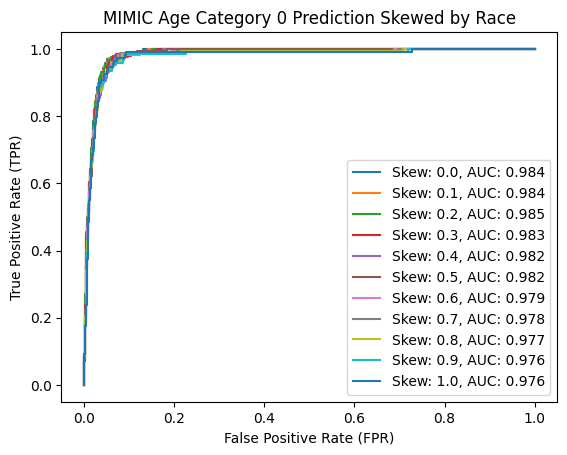

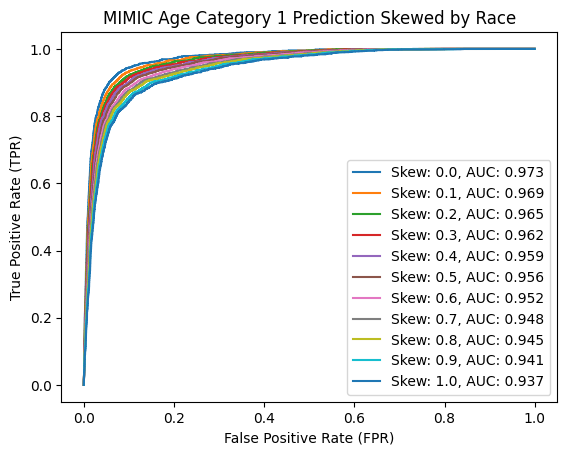

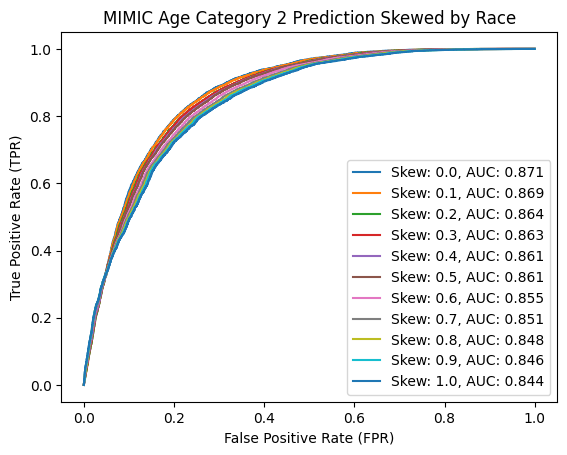

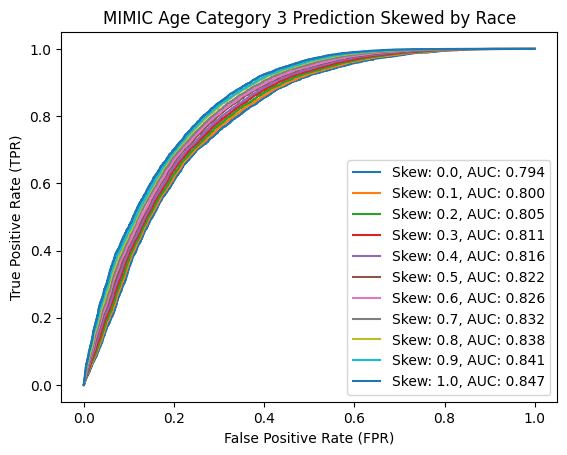

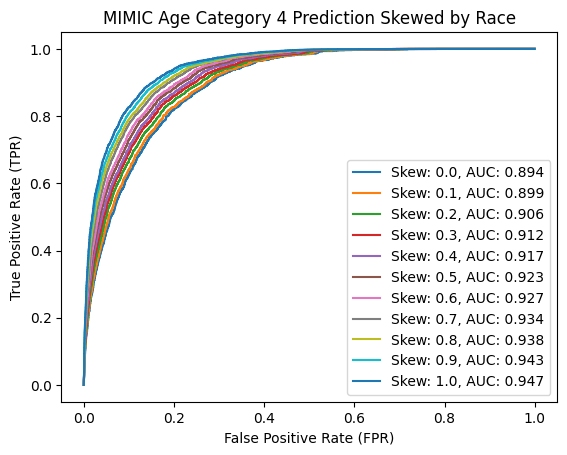

In [ ]:
ages = [0, 1, 2, 3, 4]
for age in ages:
  df = pd.read_csv(path + '/mimic_age_mimic_test.csv')
  df = df.rename(columns={'age': 'Age'})
  df = df[~df['Race/Ethnicity'].isna()]
  df = df[df['Race/Ethnicity']!='Unknown']

  df['Age_Probability'] = df['Age_Probability'].str.rstrip(']')
  df['Age_Probability'] = df['Age_Probability'].str.lstrip('[')
  df['Age_Probability'] = df['Age_Probability'].apply(np.fromstring, sep=',', dtype = float)
  age_df, nonage_df = binarize_by_age(df, age)
  for bias in np.arange(0, 1.1, 0.1):
      biased_test_df = create_race_biased_test_set(age_df, nonage_df, bias)
      fpr, tpr, _ = metrics.roc_curve(y_true = biased_test_df['Patient Age Category'],y_score = [prob[age] for prob in biased_test_df['Age_Probability']], pos_label = age)
      auc = metrics.auc(fpr, tpr)
      plt.plot(fpr, tpr, label=f'Skew: {bias:.1f}, AUC: {auc:.3f}')
  # Add labels, title, and legend
  plt.xlabel('False Positive Rate (FPR)')
  plt.ylabel('True Positive Rate (TPR)')
  plt.legend(loc='lower right')
  plt.title('MIMIC Age Category ' + str(age) + ' Prediction Skewed by Race')
  # Show the plot
  plt.show()

MIMIC Trained;
CheXpert Tested

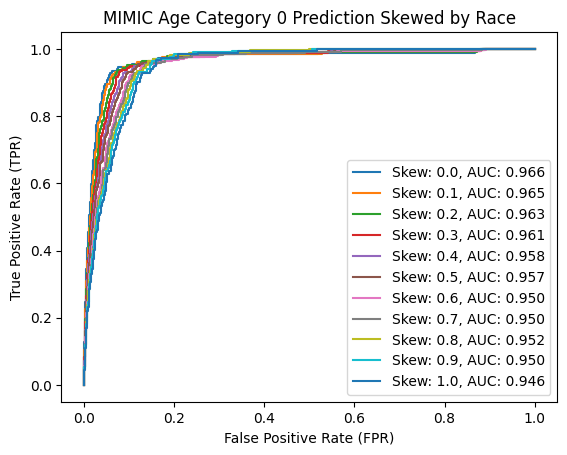

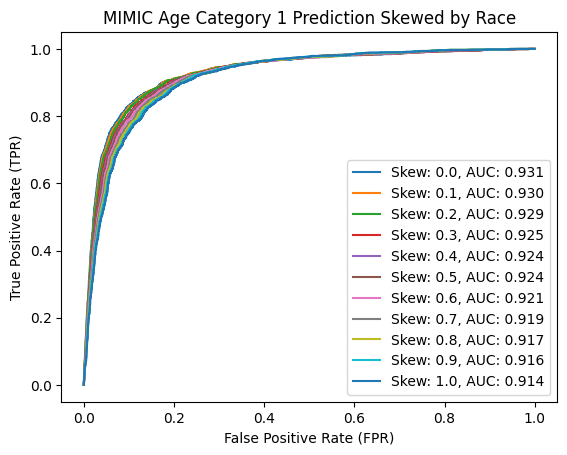

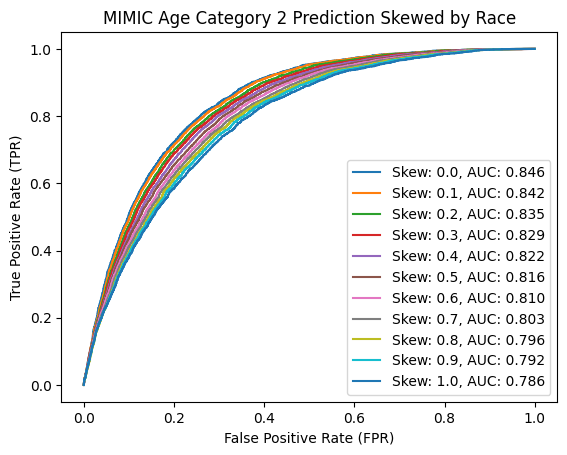

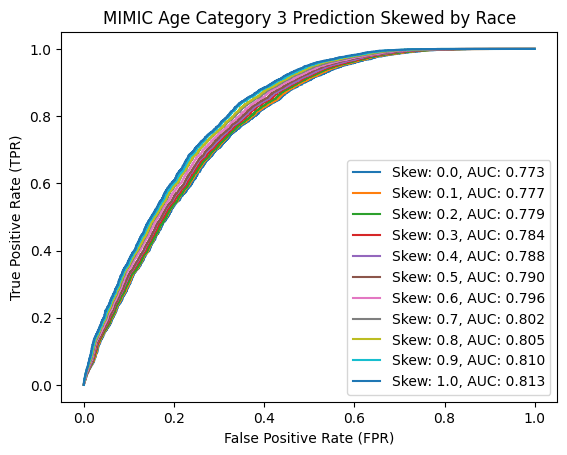

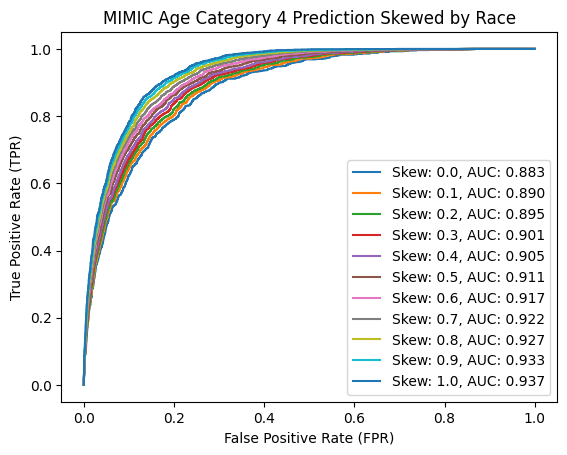

In [ ]:
ages = [0, 1, 2, 3, 4]
for age in ages:
  df = pd.read_csv(path + '/mimic_age_chexpert_test.csv')
  df = df.rename(columns={'age': 'Age'})
  df.loc[df['PRIMARY_RACE'] == 'Asian', 'Race/Ethnicity'] = 'Non-Hispanic Asian'
  df.loc[df['PRIMARY_RACE'] == 'Black', 'Race/Ethnicity'] = 'Non-Hispanic Black'
  df.loc[df['PRIMARY_RACE'] == 'White', 'Race/Ethnicity'] = 'Non-Hispanic White'
  df.loc[df['PRIMARY_RACE'] == 'Native American', 'Race/Ethnicity'] = 'Other'
  df.loc[df['PRIMARY_RACE'] == 'Other', 'Race/Ethnicity'] = 'Other'
  df.loc[df['PRIMARY_RACE'] == 'Unknown', 'Race/Ethnicity'] = 'Unknown'
  df.loc[df['ETHNICITY'] == 'Hispanic/Latino', 'Race/Ethnicity'] = 'Other'
  df = df[~df['Race/Ethnicity'].isna()]
  df = df[df['Race/Ethnicity']!='Unknown']
  df = df.reset_index()

  df['Age_Probability'] = df['Age_Probability'].str.rstrip(']')
  df['Age_Probability'] = df['Age_Probability'].str.lstrip('[')
  df['Age_Probability'] = df['Age_Probability'].apply(np.fromstring, sep=',', dtype = float)
  age_df, nonage_df = binarize_by_age(df, age)
  for bias in np.arange(0, 1.1, 0.1):
      biased_test_df = create_race_biased_test_set(age_df, nonage_df, bias)
      fpr, tpr, _ = metrics.roc_curve(y_true = biased_test_df['Patient Age Category'],y_score = [prob[age] for prob in biased_test_df['Age_Probability']], pos_label = age)
      auc = metrics.auc(fpr, tpr)
      plt.plot(fpr, tpr, label=f'Skew: {bias:.1f}, AUC: {auc:.3f}')
  # Add labels, title, and legend
  plt.xlabel('False Positive Rate (FPR)')
  plt.ylabel('True Positive Rate (TPR)')
  plt.legend(loc='lower right')
  plt.title('MIMIC Age Category ' + str(age) + ' Prediction Skewed by Race')
  # Show the plot
  plt.show()